# Phase space reconstruction of non-Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
data_dir = 'data'
p0c = 43.36e6 # reference momentum in eV/c
gt_beam = create_beam(base_yaml = os.path.join(data_dir,'base.yaml'),
                      transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
                      p0c = p0c,
                      n_particle = 1_000_000,
                      save_as = os.path.join('data', 'linear_beam.pt')
                      )

ground truth distribution saved at data/linear_beam.pt


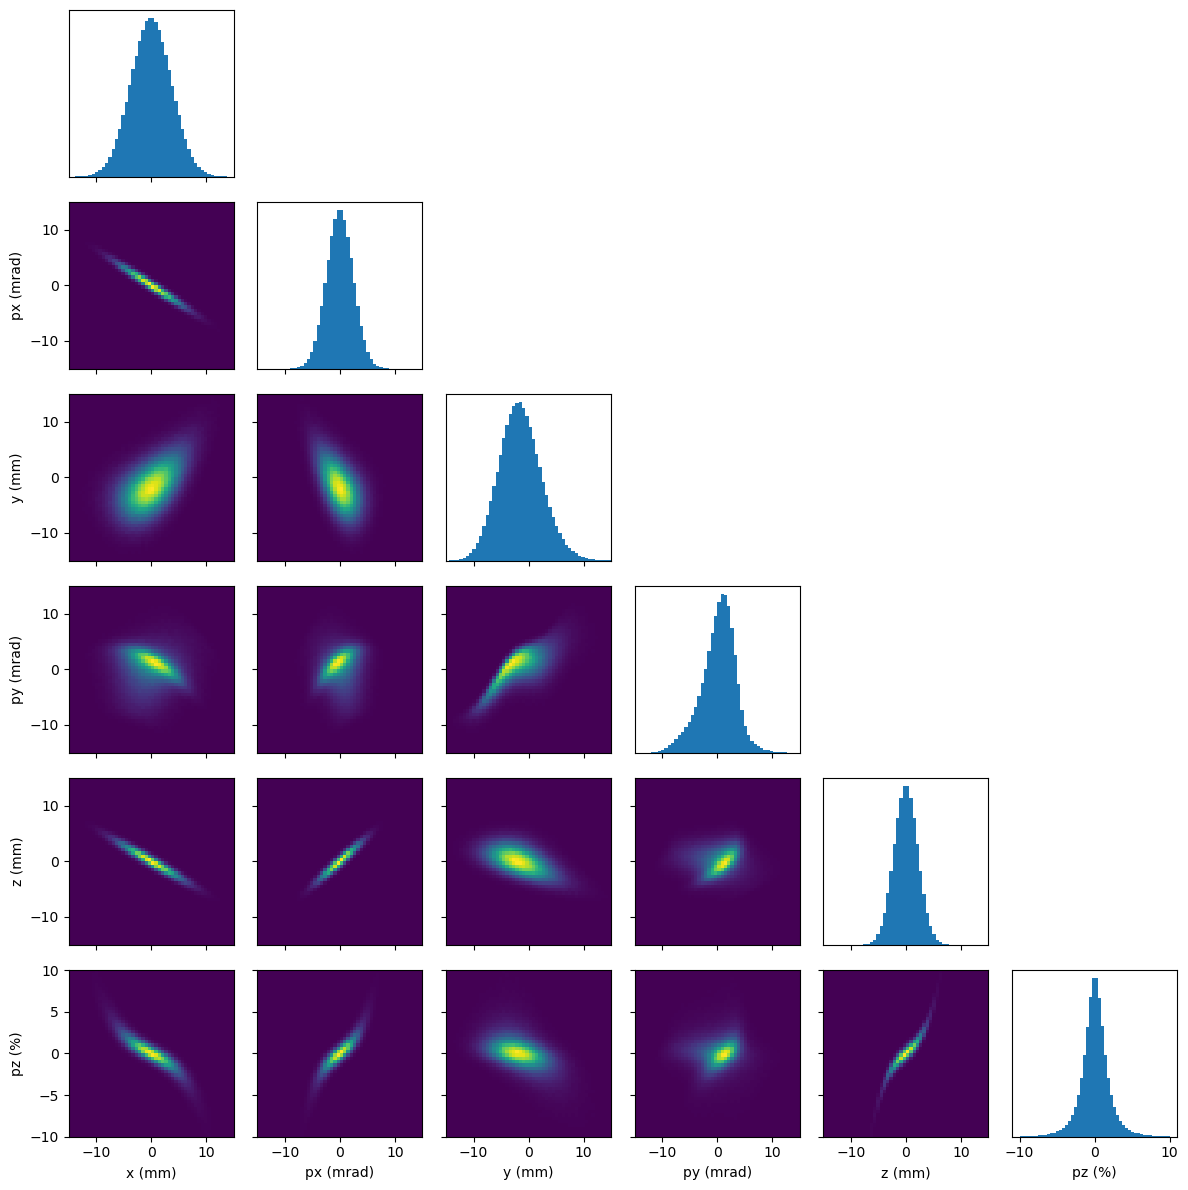

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-10e-2, 10e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 = 7.570125
k2 = -15.704693
k3 = 1.0

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 5e6]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join('data', 'train.dset')
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

dataset saved as 'data/train.dset'
torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


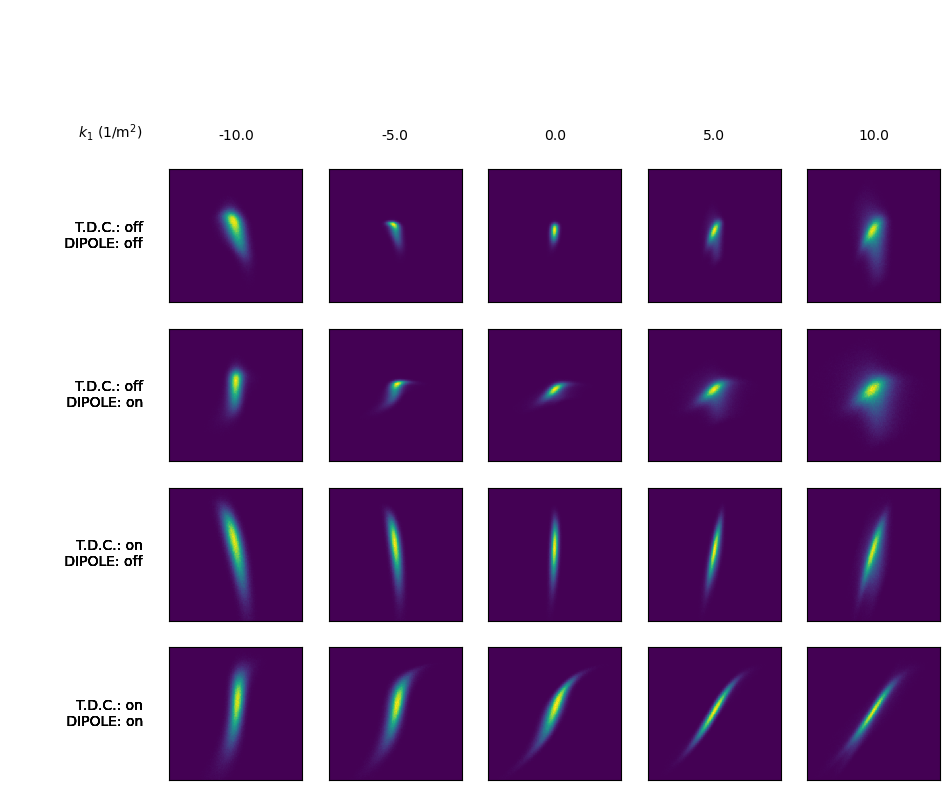

In [7]:
fig, ax = plot_3d_scan_data(train_dset_3d_scan)
plt.show()

### 10,000 particles

In [8]:
%%time

# training
pred_beam = train_3d_scan_parallel_gpus(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 10_000, 
    device = 'cuda:0'
    )

Using device: cuda:0


/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680572619157/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor([2408065.2500, 2408065.2500, 2408065.2500, 2408065.2500],
       device='cuda:0', grad_fn=<MulBackward0>)
100 tensor([766069.3125, 766069.3125, 766069.3125, 766069.3125], device='cuda:0',
       grad_fn=<MulBackward0>)
200 tensor([805529.8125, 805529.8125, 805529.8125, 805529.8125], device='cuda:0',
       grad_fn=<MulBackward0>)
300 tensor([742672.1875, 742672.1875, 742672.1875, 742672.1875], device='cuda:0',
       grad_fn=<MulBackward0>)
400 tensor([736367.7500, 736367.7500, 736367.7500, 736367.7500], device='cuda:0',
       grad_fn=<MulBackward0>)
500 tensor([699199.6250, 699199.6250, 699199.6250, 699199.6250], device='cuda:0',
       grad_fn=<MulBackward0>)
600 tensor([726194.2500, 726194.2500, 726194.2500, 726194.2500], device='cuda:0',
       grad_fn=<MulBackward0>)
700 tensor([715134.2500, 715134.2500, 715134.2500, 715134.2500], device='cuda:0',
       grad_fn=<MulBackward0>)
800 tensor([680219., 680219., 680219., 680219.], device='cuda:0',
       grad_fn=<MulBackward0

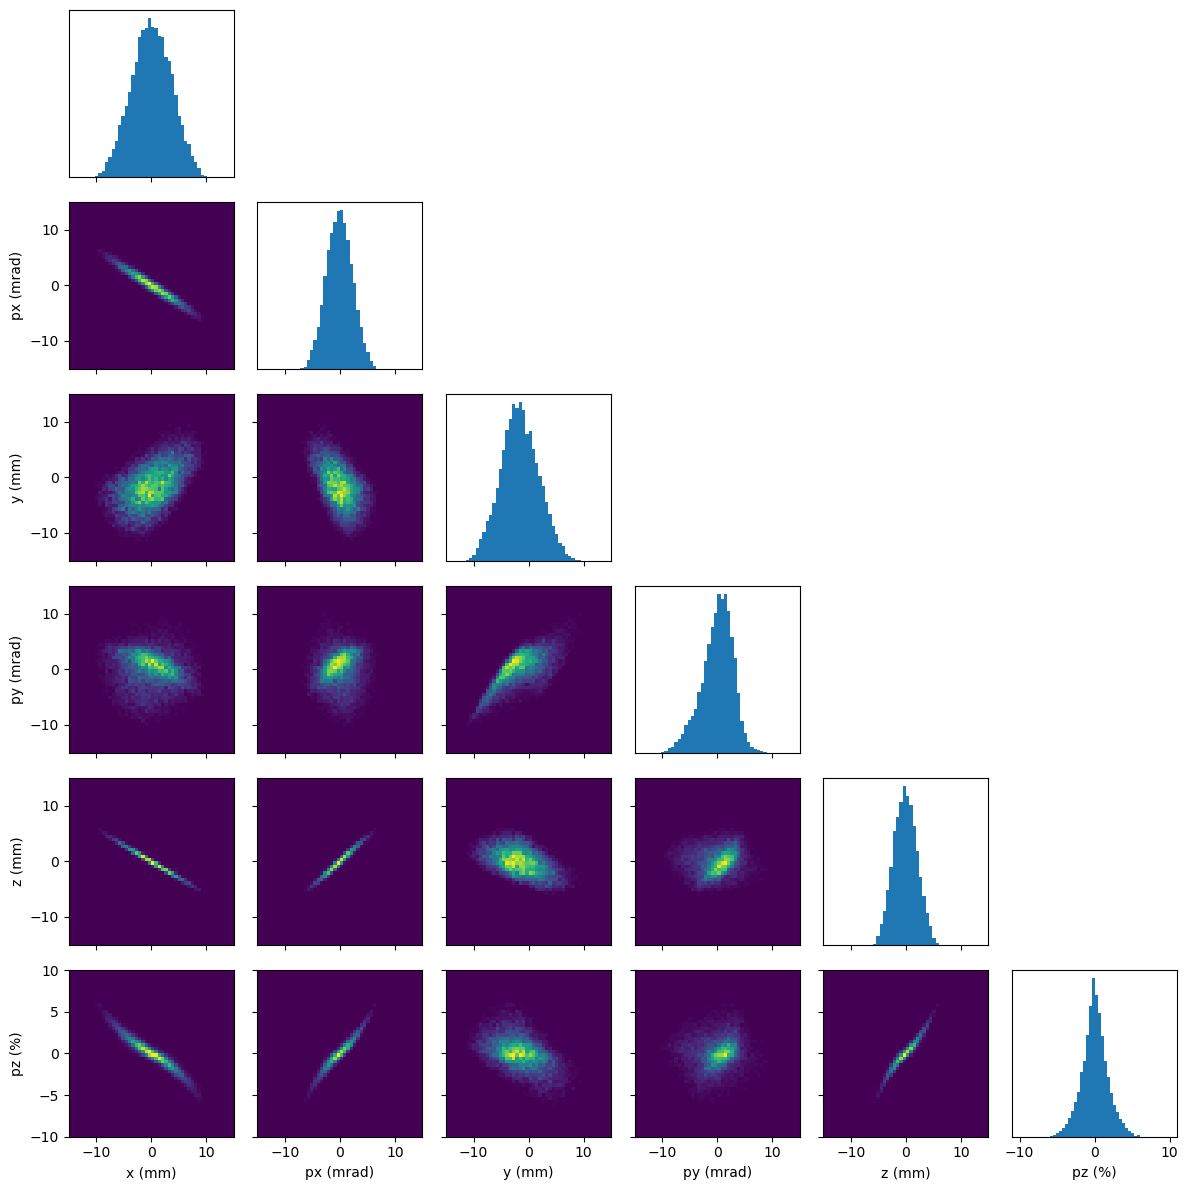

In [9]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

In [10]:
torch.cuda.empty_cache()

In [11]:
torch.save(pred_beam, os.path.join(data_dir, '3D_scan_10_000.pt'))

### 100,000 particles

In [12]:
# training
pred_beam = train_3d_scan_parallel_gpus(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0
0 tensor([2689251.7500, 2689251.7500, 2689251.7500, 2689251.7500],
       device='cuda:0', grad_fn=<MulBackward0>)
100 tensor([415676.6250, 415676.6250, 415676.6250, 415676.6250], device='cuda:0',
       grad_fn=<MulBackward0>)
200 tensor([331183.6250, 331183.6250, 331183.6250, 331183.6250], device='cuda:0',
       grad_fn=<MulBackward0>)
300 tensor([334086.8125, 334086.8125, 334086.8125, 334086.8125], device='cuda:0',
       grad_fn=<MulBackward0>)
400 tensor([290894.9375, 290894.9375, 290894.9375, 290894.9375], device='cuda:0',
       grad_fn=<MulBackward0>)
500 tensor([293552.8125, 293552.8125, 293552.8125, 293552.8125], device='cuda:0',
       grad_fn=<MulBackward0>)
600 tensor([295078.4062, 295078.4062, 295078.4062, 295078.4062], device='cuda:0',
       grad_fn=<MulBackward0>)
700 tensor([290386.5000, 290386.5000, 290386.5000, 290386.5000], device='cuda:0',
       grad_fn=<MulBackward0>)
800 tensor([277202.8438, 277202.8438, 277202.8438, 277202.8438], device='

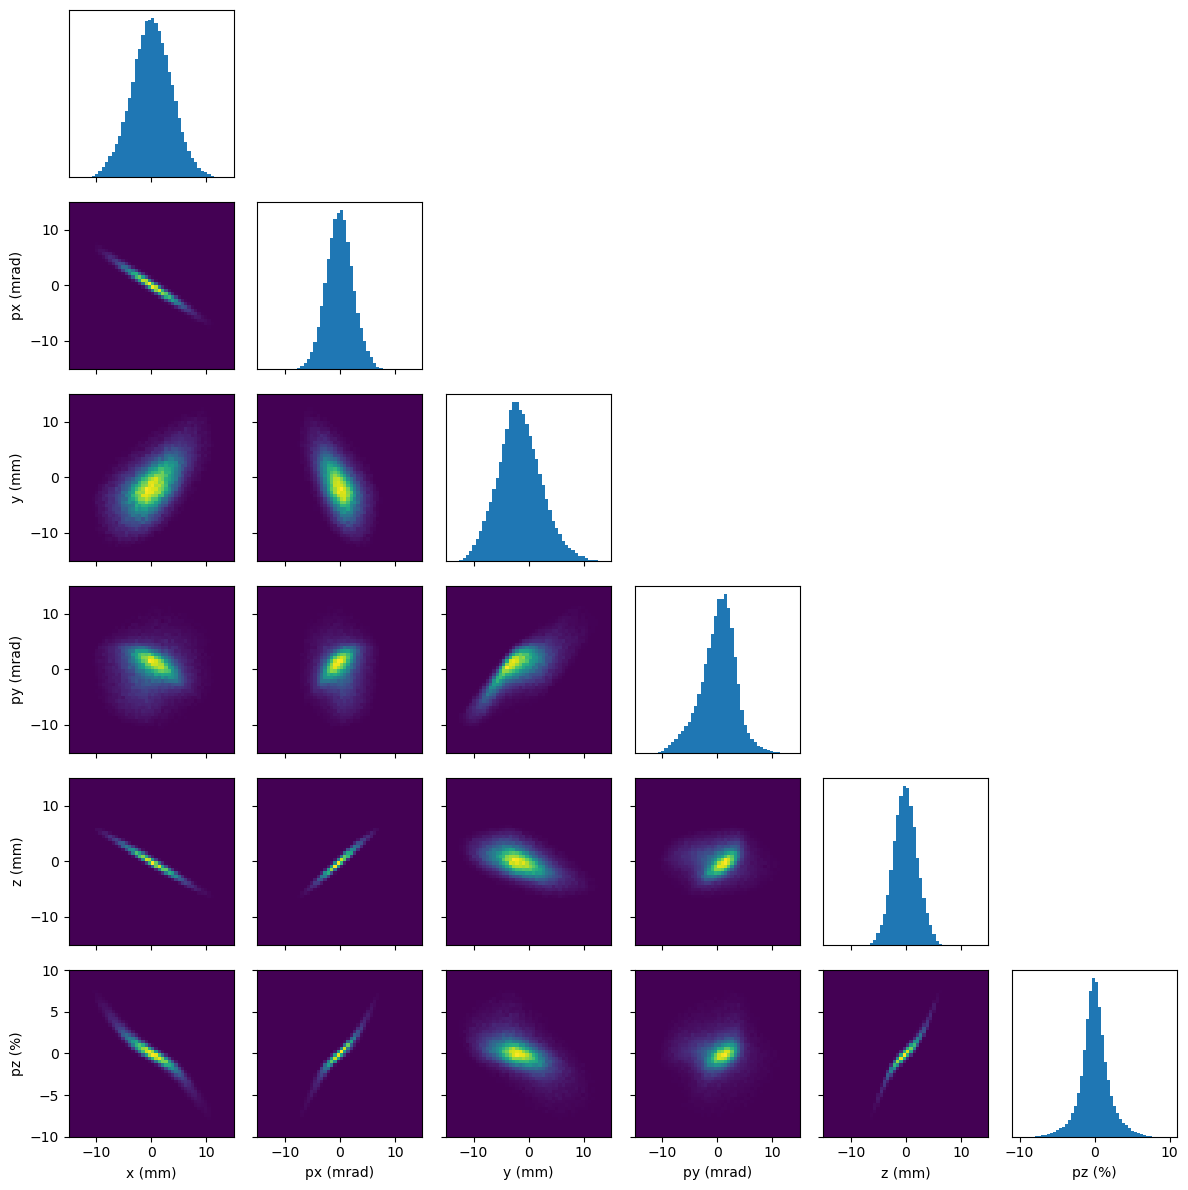

In [13]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

In [14]:
torch.save(pred_beam, os.path.join(data_dir, '3D_scan_100_000.pt'))

In [15]:
torch.cuda.empty_cache()

### 1,000,000 particles

In [16]:
# training
pred_beam = train_3d_scan_parallel_gpus(
    train_dset_3d_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 1_000_000, 
    device = 'cuda'
    )

Using device: cuda
0 tensor([3736859.7500, 3736859.7500, 3736859.7500, 3736859.7500],
       device='cuda:0', grad_fn=<MulBackward0>)
100 tensor([361589.0625, 361589.0625, 361589.0625, 361589.0625], device='cuda:0',
       grad_fn=<MulBackward0>)
200 tensor([373282.4688, 373282.4688, 373282.4688, 373282.4688], device='cuda:0',
       grad_fn=<MulBackward0>)
300 tensor([321404.2812, 321404.2812, 321404.2812, 321404.2812], device='cuda:0',
       grad_fn=<MulBackward0>)
400 tensor([205946.2188, 205946.2188, 205946.2188, 205946.2188], device='cuda:0',
       grad_fn=<MulBackward0>)
500 tensor([229403.2812, 229403.2812, 229403.2812, 229403.2812], device='cuda:0',
       grad_fn=<MulBackward0>)
600 tensor([191878.8125, 191878.8125, 191878.8125, 191878.8125], device='cuda:0',
       grad_fn=<MulBackward0>)
700 tensor([320758.9688, 320758.9688, 320758.9688, 320758.9688], device='cuda:0',
       grad_fn=<MulBackward0>)
800 tensor([215475., 215475., 215475., 215475.], device='cuda:0',
       gr

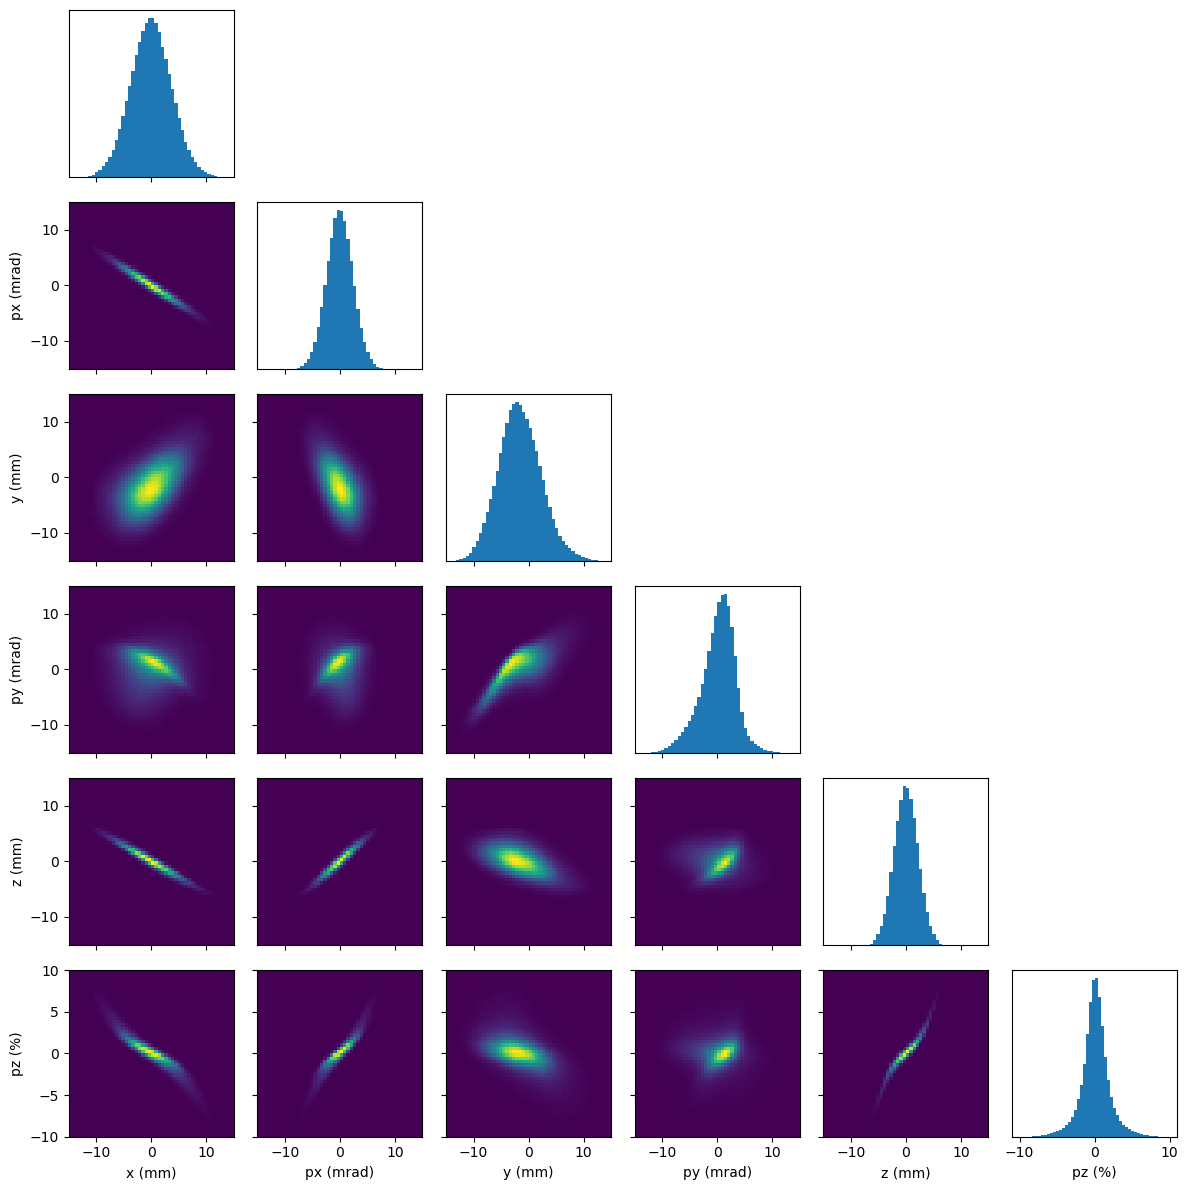

In [17]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

In [18]:
torch.save(pred_beam, os.path.join(data_dir, '3D_scan_1_000_000.pt'))

In [19]:
torch.cuda.empty_cache()

## 'T' scan

In [20]:
# generate and save train and test datasets
train_dset_t_scan = run_t_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    save_as = os.path.join('data', 'train.dset')
    )

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

torch.Size([8, 3, 1])
tensor([[-1.0000e+01,  0.0000e+00,  2.2200e-16],
        [-5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 5.0000e+00,  0.0000e+00,  2.2200e-16],
        [ 1.0000e+01,  0.0000e+00,  2.2200e-16],
        [ 0.0000e+00,  0.0000e+00,  9.5634e-01],
        [ 0.0000e+00,  5.0000e+06,  2.2200e-16],
        [ 0.0000e+00,  5.0000e+06,  9.5634e-01]])
dataset saved as 'data/train.dset'
torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


In [21]:
# training
pred_beam = train_3d_scan_parallel_gpus(
    train_dset_t_scan, 
    lattice, 
    p0c, 
    screen,
    ids = scan_ids,
    n_epochs = 1_000, 
    n_particles = 100_000, 
    device = 'cuda:0'
    )

Using device: cuda:0
0 tensor([4833930., 4833930., 4833930., 4833930.], device='cuda:0',
       grad_fn=<MulBackward0>)
100 tensor([446427.9688, 446427.9688, 446427.9688, 446427.9688], device='cuda:0',
       grad_fn=<MulBackward0>)
200 tensor([326675.8750, 326675.8750, 326675.8750, 326675.8750], device='cuda:0',
       grad_fn=<MulBackward0>)
300 tensor([282047.8750, 282047.8750, 282047.8750, 282047.8750], device='cuda:0',
       grad_fn=<MulBackward0>)
400 tensor([246942.5625, 246942.5625, 246942.5625, 246942.5625], device='cuda:0',
       grad_fn=<MulBackward0>)
500 tensor([268821.3750, 268821.3750, 268821.3750, 268821.3750], device='cuda:0',
       grad_fn=<MulBackward0>)
600 tensor([250996.6250, 250996.6250, 250996.6250, 250996.6250], device='cuda:0',
       grad_fn=<MulBackward0>)
700 tensor([227400.7969, 227400.7969, 227400.7969, 227400.7969], device='cuda:0',
       grad_fn=<MulBackward0>)
800 tensor([215698.1562, 215698.1562, 215698.1562, 215698.1562], device='cuda:0',
       

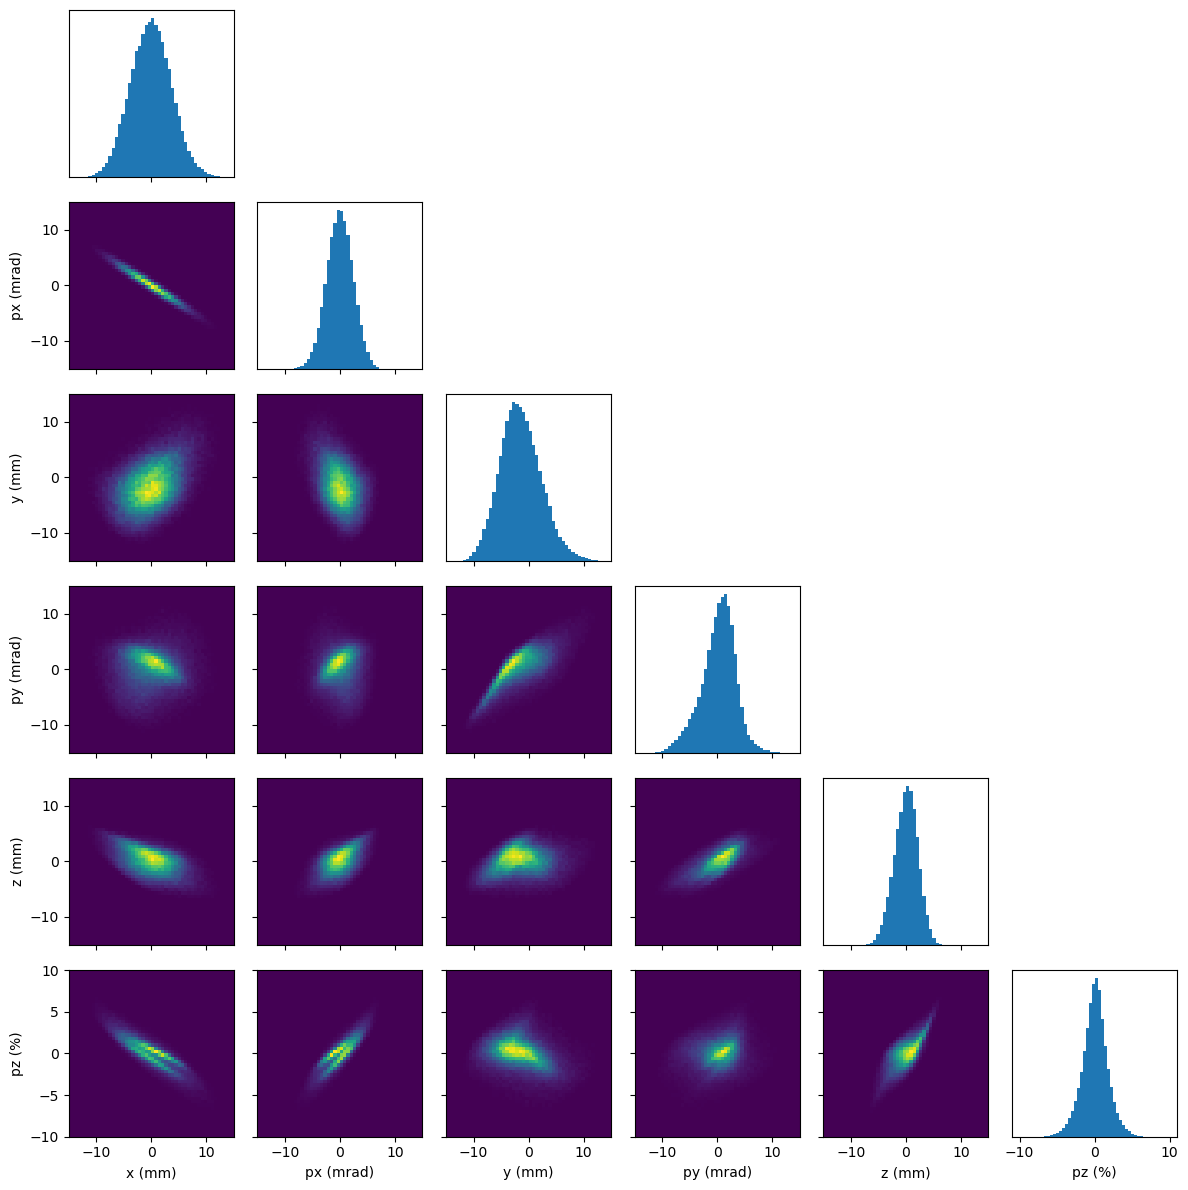

In [22]:
# reconstructed beam projections:
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           custom_lims = lims
                           )
plt.show()

In [23]:
torch.cuda.empty_cache()

In [24]:
torch.save(pred_beam, os.path.join(data_dir, 't_scan_100_000.pt'))